In [2]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [4]:
df = pd.read_csv("Datasets/bhp.csv")
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250


In [5]:
df.price_per_sqft.describe()

count    1.320000e+04
mean     7.920337e+03
std      1.067272e+05
min      2.670000e+02
25%      4.267000e+03
50%      5.438000e+03
75%      7.317000e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

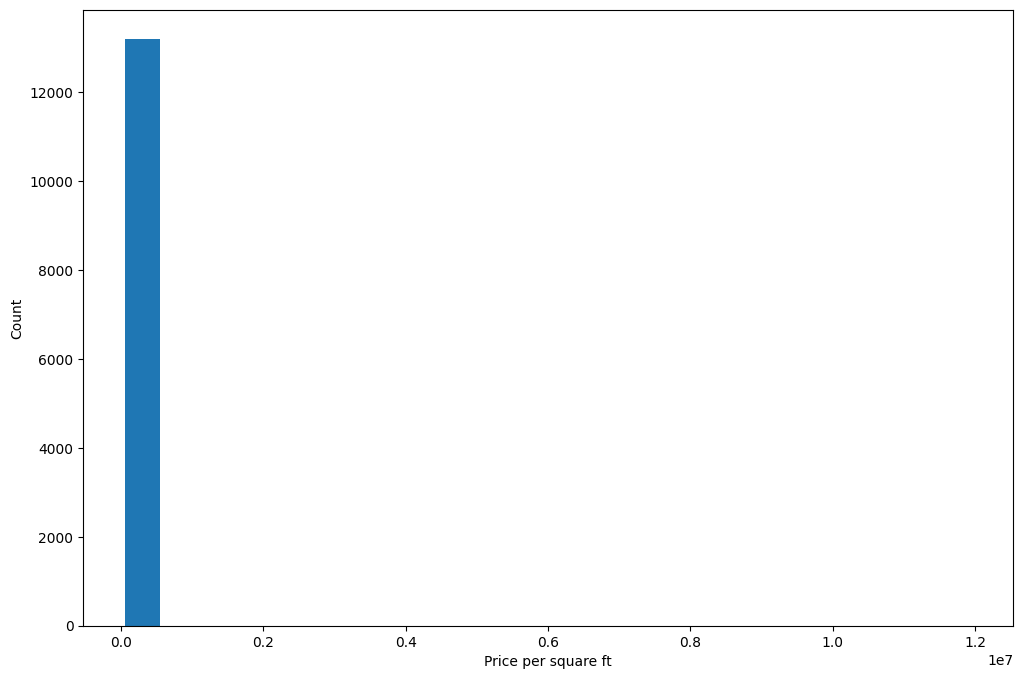

In [7]:
plt.hist(df.price_per_sqft, bins=20, rwidth=0.8)
plt.xlabel('Price per square ft')
plt.ylabel('Count')
plt.show()

Above chart confirms our understanding that this dataset has some bad outliers. Because we see only one bar with more than 12000 data points but on the right hand side there are data points that have higher value for price per sqft but count of these data points is very tiny compared to 12000 hence we can hardly see any bar

Using log scale can make visualization little better

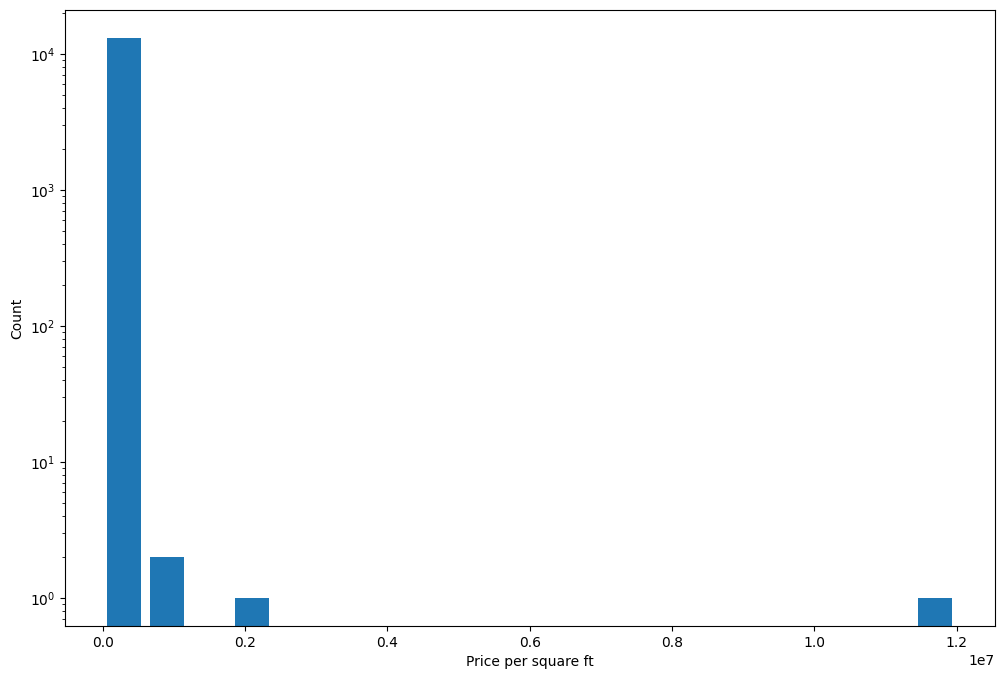

In [8]:
plt.hist(df.price_per_sqft, bins=20, rwidth=0.8)
plt.xlabel('Price per square ft')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

You see atleast few bars on right hand side of our highest building at least :)



### (1) Treat outliers using percentile first

In [9]:
lower_limit, upper_limit = df.price_per_sqft.quantile([0.001, 0.999])
lower_limit, upper_limit

(1366.184, 50959.36200000098)

In [10]:
outliers = df[(df.price_per_sqft>upper_limit) | (df.price_per_sqft<lower_limit)]
outliers.sample(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
12328,other,4 Bedroom,4350.0,8.0,2600.0,4,59770
3934,other,1 BHK,1500.0,1.0,19.5,1,1300
11635,Begur,3 BHK,2400.0,3.0,12.0,3,500
7862,JP Nagar,3 BHK,20000.0,3.0,175.0,3,875
7575,other,1 BHK,425.0,1.0,750.0,1,176470
5343,other,9 BHK,42000.0,8.0,175.0,9,416
2392,other,4 Bedroom,2000.0,3.0,25.0,4,1250
9144,other,4 Bedroom,10961.0,4.0,80.0,4,729
5911,Mysore Road,1 Bedroom,45.0,1.0,23.0,1,51111
665,Yelahanka,3 BHK,35000.0,3.0,130.0,3,371


Above shows properties that has price_per_sqft value such as 500 rs which is very very low for the city of banglore. You would be very lucky if you can find such as property :) Also we have properties that has price per sqft value such as 12000000 which is way too high. It seems almost impossible and even if it is legitimate it can help data analysis process if we remove such a data point

In [11]:
df2 = df[(df.price_per_sqft<upper_limit) & (df.price_per_sqft>lower_limit)]
df2.shape

(13172, 7)

In [12]:
df.shape

(13200, 7)

In [13]:
df.shape[0] - df2.shape[0]

28

We removed total 28 outliers

### (2) Now remove outliers using 4 standard deviation

In [14]:
max_limit = df2.price_per_sqft.mean() + 4*df2.price_per_sqft.std()
min_limit = df2.price_per_sqft.mean() - 4*df2.price_per_sqft.std()
max_limit, min_limit

(np.float64(23227.73653589432), np.float64(-9900.429065502582))

In [15]:
df2[(df2.price_per_sqft>max_limit) | (df2.price_per_sqft<min_limit)].sample(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5974,other,4 Bedroom,2360.0,4.0,650.0,4,27542
8483,HSR Layout,8 Bedroom,800.0,8.0,285.0,8,35625
9099,Whitefield,3 BHK,1496.0,2.0,718.0,3,47994
8082,Nagarbhavi,4 Bedroom,1200.0,3.0,340.0,4,28333
2830,BTM 2nd Stage,4 Bedroom,1500.0,2.0,450.0,4,30000
3935,other,4 Bedroom,2360.0,4.0,600.0,4,25423
4350,other,5 Bedroom,1750.0,5.0,450.0,5,25714
6744,HAL 2nd Stage,2 Bedroom,600.0,3.0,145.0,2,24166
1705,other,4 Bedroom,1700.0,2.0,550.0,4,32352
9791,other,4 Bedroom,1200.0,5.0,325.0,4,27083


In [16]:
df3 = df2[(df2.price_per_sqft>min_limit) & (df2.price_per_sqft<max_limit)]
df3.shape

(13047, 7)

In [17]:
df2.shape[0]-df3.shape[0]

125

In this step we removed total 125 outliers

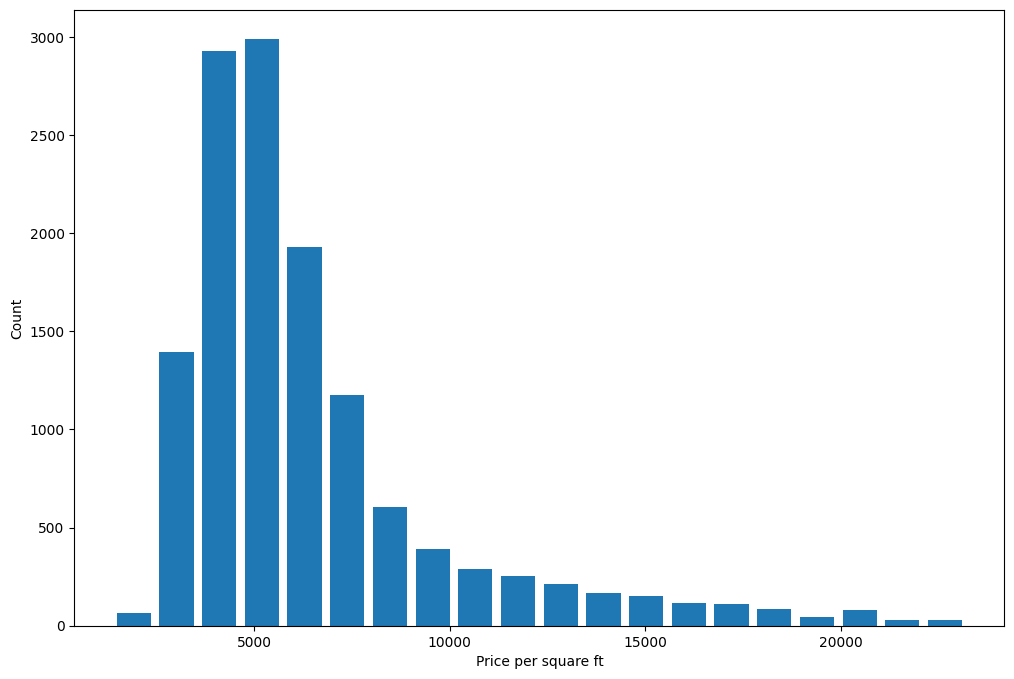

In [18]:
plt.hist(df3.price_per_sqft, bins=20, rwidth=0.8)
plt.xlabel('Price per square ft')
plt.ylabel('Count')
plt.show()

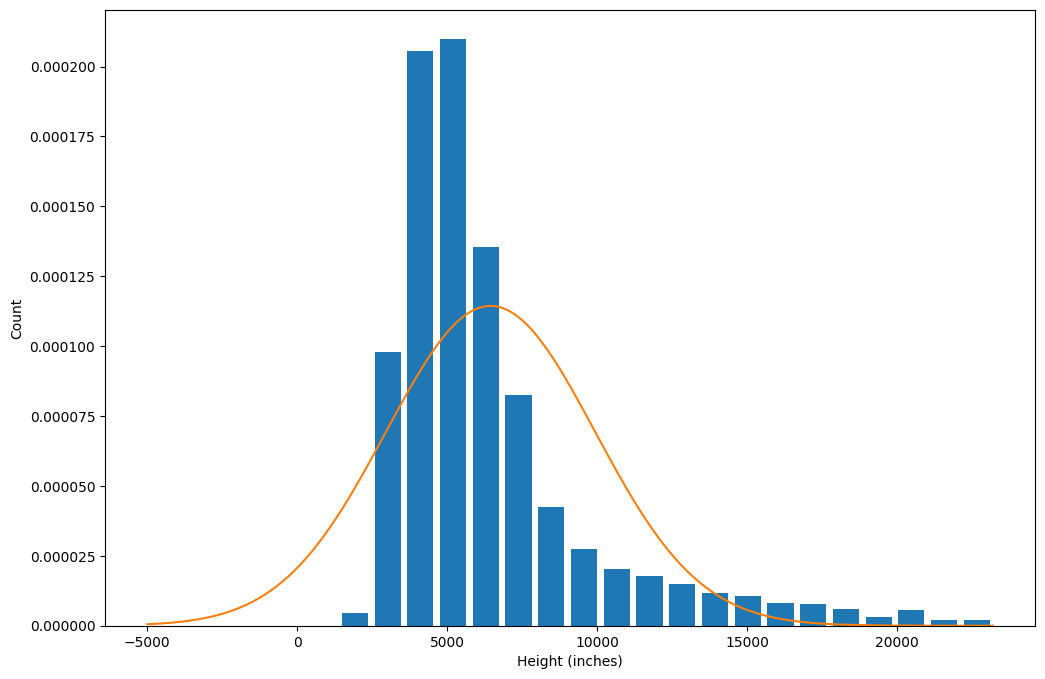

In [20]:
from scipy.stats import norm
import numpy as np

plt.hist(df3.price_per_sqft, bins=20, rwidth=0.8, density=True)
plt.xlabel('Height (inches)')
plt.ylabel('Count')

rng = np.arange(-5000, df3.price_per_sqft.max(), 100)
plt.plot(rng, norm.pdf(rng,df3.price_per_sqft.mean(),df3.price_per_sqft.std()))
plt.show()

### (3) Now remove outliers using z score. Use z score of 4 as your thresold

In [21]:
df2['zscore'] = (df2.price_per_sqft-df2.price_per_sqft.mean())/df2.price_per_sqft.std()
df2.sample(10)

/var/folders/w8/f7n565ys1hbd_z386n7s3d480000gn/T/ipykernel_10206/2359059835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['zscore'] = (df2.price_per_sqft-df2.price_per_sqft.mean())/df2.price_per_sqft.std()


,location,size,total_sqft,bath,price,bhk,price_per_sqft,zscore
9585,Talaghattapura,3 BHK,1575.0,3.0,80.0,3,5079,-0.382672
11309,other,3 BHK,1690.0,3.0,50.0,3,2958,-0.894865
574,other,1 Bedroom,540.0,1.0,36.0,1,6666,0.000567
4968,Kanakpura Road,2 BHK,1366.0,2.0,83.0,2,6076,-0.141910
8994,Rajaji Nagar,2 BHK,1268.0,2.0,127.0,2,10015,0.809304
6845,2nd Stage Nagarbhavi,4 Bedroom,600.0,4.0,125.0,4,20833,3.421704
10374,Electronic City,3 Bedroom,1400.0,3.0,90.0,3,6428,-0.056907
9875,other,3 BHK,1430.0,3.0,70.0,3,4895,-0.427106
9963,other,2 BHK,1450.0,2.0,90.0,2,6206,-0.110517
7329,Hormavu,2 BHK,1000.0,2.0,50.0,2,5000,-0.401750


In [22]:
outliers_z = df2[(df2.zscore < -4) | (df2.zscore>4)]
outliers_z.shape

(125, 8)

In [23]:
outliers_z.sample(5)

,location,size,total_sqft,bath,price,bhk,price_per_sqft,zscore
3675,Kasturi Nagar,5 Bedroom,1650.0,5.0,450.0,5,27272,4.976634
1078,other,4 Bedroom,2400.0,5.0,775.0,4,32291,6.188654
12352,other,6 Bedroom,2400.0,5.0,750.0,6,31250,5.937267
1705,other,4 Bedroom,1700.0,2.0,550.0,4,32352,6.203385
11650,other,5 Bedroom,9600.0,7.0,2736.0,5,28500,5.273180


In [24]:
df4 = df2[(df2.zscore>-4)&(df2.zscore<4)]
df4.shape

(13047, 8)

In [25]:
df2.shape[0] - df4.shape[0]

125

In this step also we removed 125 outliers. The result would be exactly same as 4 standard deviation